<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Установка-и-загрузка-необходимых-библиотек" data-toc-modified-id="Установка-и-загрузка-необходимых-библиотек-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Установка и загрузка необходимых библиотек</a></span></li><li><span><a href="#Загрузка-датафрейма" data-toc-modified-id="Загрузка-датафрейма-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Загрузка датафрейма</a></span></li><li><span><a href="#Функция-общего-анализа" data-toc-modified-id="Функция-общего-анализа-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>Функция общего анализа</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

#### Установка и загрузка необходимых библиотек

In [ ]:
import sys

!{sys.executable} -m pip install -U joblib -q
#!{sys.executable} -m pip install -U pytorch-transformers -q

!{sys.executable} -m pip install -U catboost -q
!{sys.executable} -m pip install -U nltk -q
!{sys.executable} -m pip install -U wordcloud -q
!{sys.executable} -m pip install -U spacy -q
!{sys.executable} -m spacy download en_core_web_sm -q
!{sys.executable} -m pip install -U imblearn -q
!{sys.executable} -m pip install -U optuna -q
#!{sys.executable} -m pip install -U ipywidgets -q
#!{sys.executable} -m pip install -U keras -q

In [22]:
import sys
!{sys.executable} -m pip install -U dask -q
!{sys.executable} -m pip install -U dask[distributed] -q

In [ ]:
# Этот кусок кода существует.
#gpu_info = !nvidia-smi
#gpu_info = '\n'.join(gpu_info)
#if gpu_info.find('failed') >= 0:
#  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
#  print('and then re-execute this cell.')
#else:
#  print(gpu_info)

In [34]:
import os
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

import optuna

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle


from catboost import CatBoostClassifier
#import lightgbm
#from lightgbm import LGBMClassifier
 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet
#from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud
import spacy
#import gc
from nltk.stem import PorterStemmer
from joblib import Parallel, delayed
import dask
from dask.distributed import Client

#import time 
import timeit
 
#import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

#from pytorch_transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification

#from IPython.display import clear_output

#import io

#import torch
#from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Загрузка датафрейма

In [2]:
# адреса расположения датасета
HOME_PATH = 'lem_toxic.csv'
SERVER_PATH = '/datasets/toxic_comments.csv'

if os.path.exists(HOME_PATH):
    df = pd.read_csv(HOME_PATH, index_col=0)
elif os.path.exists(SERVER_PATH):
    df = pd.read_csv(SERVER_PATH, index_col=0)


#### Функция общего анализа

In [3]:
def inform(data):
    # Вывод информации о датасете
    print("Информация о датасете:")
    data.info()
    
    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    # Вывод первых нескольких строк датасета
    print("Первые несколько строк датасета:")
    display(data.head())
    
    # Разделительная строка
    print("\n" + "="*50 + "\n")

    # Облако слов для категориальных значений
    print('Облако слов для категориальных значений')
    categorical_cols = data.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(str(data[col]))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.title(f'Облако слов для {col}')
        plt.show()

Функция downsample

In [4]:
def downsample(features, target, fraction):
    features_0 = features[target == 0]
    features_1 = features[target == 1]
    target_0 = target[target == 0]
    target_1 = target[target == 1]

    features_downsampled = pd.concat(
        [features_0.sample(frac=fraction, random_state=12345)] + [features_1])
    target_downsampled = pd.concat(
        [target_0.sample(frac=fraction, random_state=12345)] + [target_1])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

Функция для стэмминга

In [5]:
stemmer = PorterStemmer()

def stem_text(text):
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

SpaCy функция предварительной обработки и лемматизации текста

In [6]:
nlp = spacy.load('en_core_web_sm')

def preprocess_and_lemmatize(text):
    # Удаление не-буквенных символов
    cleared_text = re.sub(r'[^a-zA-Z0-9]', " ", text)
    # Токенизация текста
    doc = nlp(cleared_text)
    # Лемматизация токенов
    lemmatized_text = [token.lemma_ for token in doc]
    return " ".join(lemmatized_text)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             159292 non-null  object
 1   toxic            159292 non-null  int64 
 2   lemmatized_text  159292 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.9+ MB


Первые несколько строк датасета:


,text,toxic,lemmatized_text
0,explanation\nwhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,d'aww! he matches this background colour i'm s...,0,d aww he match this background colour I m se...
2,"hey man, i'm really not trying to edit war. it...",0,hey man I m really not try to edit war it ...
3,"""\nmore\ni can't make any real suggestions on ...",0,more I can t make any real suggestion on im...
4,"you, sir, are my hero. any chance you remember...",0,you sir be my hero any chance you rememb...




Облако слов для категориальных значений


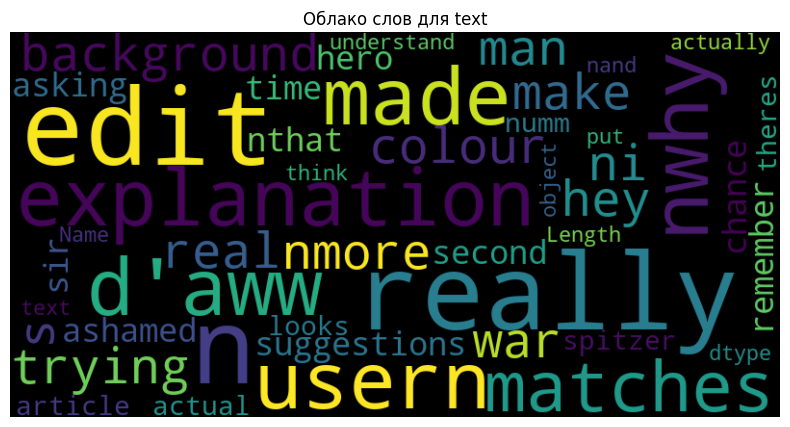

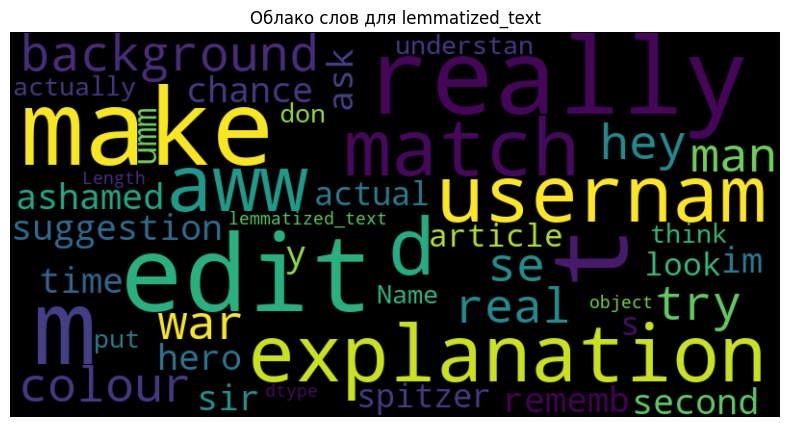

In [7]:
inform(df)

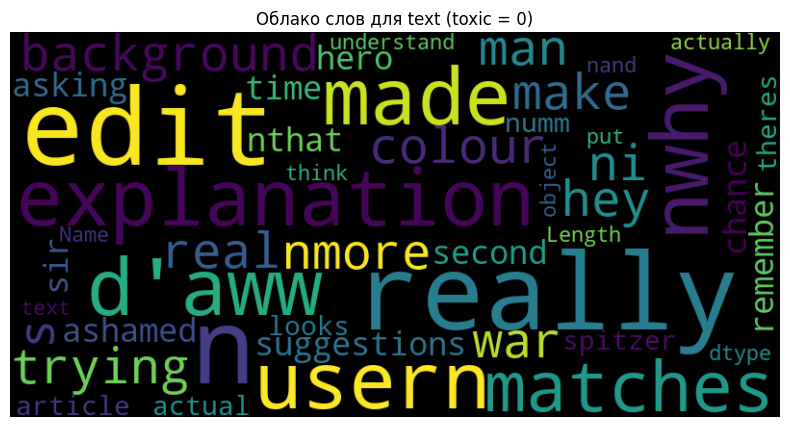

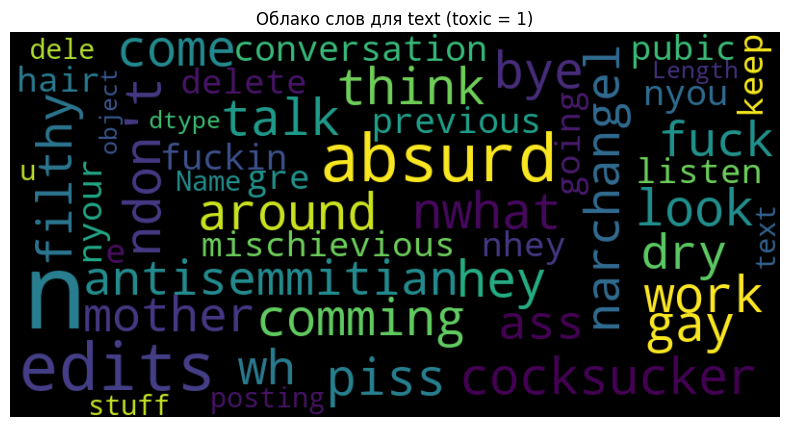

In [8]:
categorical_cols = ['text']

for toxic_value in [0, 1]:
    filtered_data = df[df['toxic'] == toxic_value]
    
    for col in categorical_cols:
        wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(str(filtered_data[col]))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.title(f'Облако слов для {col} (toxic = {toxic_value})')
        plt.show()

**Промежуточный вывод:** как мы видим, в датасете наблюдается серьёзный дисбаланс и большое количество записей, представляющих из себя строки на английском с переизбытком "похожих на буквы" символов, над чем мы и будем работать 

И как мы видим по кускам слов - люди любят затыкать мат символами, из-за чего наше облако поражает популярностью букв

приведем все буквенные данные к нижнему регистру

In [9]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.strip()

Поскольку 159тыс - это очень много, сократим выборку до 20 тыс строк с сохранением соотношения классов

По большей части потому что мой компьютер не хочет 300+ мб выделять на обработку этого в коде ниже (максимум он не мог обработать 2.18 гб)

Изменено

Произошел стэмминг c последующим сохранением в файл

Добавлена минимизация через TF-IDF

Лемматизация

In [10]:
lemmatize = nltk.WordNetLemmatizer()

In [ ]:
# Применение функции предварительной обработки и лемматизации к DataFrame
df['lemmatized_text'] = df['text'].apply(preprocess_and_lemmatize)

# Создание облаков слов для обработанного текста
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(df['lemmatized_text'].str.cat(sep=' '))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Облако слов')
plt.show()

In [ ]:
df.to_csv('lem_toxic.csv')

Лемматизация записана и больше не желаема к применению

Блок ниже - попытка через stem - он не рабочий, оставил т к интересны коментарии, почему он у меня загоняется в бесконечную рекурсию, в процессе ( хотя я убрал delayed) начинает сам на себя наслаиваться

что нужно поправить, чтобы он нормально параллелил?)

In [11]:
def simple_stem(word):
    word = re.sub(r'[^a-zA-Z0-9]', " ", word)
    return word

def stem_text(text):
    words = nltk.word_tokenize(text)
    stemmed_words = [simple_stem(word) for word in words]
    return ' '.join(stemmed_words)

stemmed_texts = Parallel(n_jobs=-1)(delayed(stem_text)(text) for text in df['text'])
df['stemmed_text'] = stemmed_texts
df.to_csv('stemmed_text.csv', index=False)


In [12]:
df.sample(n=5)

,text,toxic,lemmatized_text,stemmed_text
40219,"""\nwhat links here , showing only transclusion...",0,what link here show only transclusion ...,what links here showing only transclusion...
54215,"""\n\nhmmm, robbins\n\nforgive me for bothering...",0,hmmm robbin forgive I for bother you a...,hmmm robbins forgive me for bothering you...
89083,racism \n\nplease explain your (seemingly raci...,0,racism please explain your seemingly raci...,racism please explain your seemingly racist ...
80509,"is that right blix1900? funny, you say you do...",0,be that right blix1900 funny you say you...,is that right blix1900 funny you say you d...
108416,"""\n\nwell it not really believing the article ...",0,well it not really believe the article as ...,well it not really believing the article as...


In [13]:
# TF-IDF
vectorizer = TfidfVectorizer(min_df=0.01)

print('соотношение классов в датасете corpus\n', df.toxic.value_counts()/df.shape[0]*100)

соотношение классов в датасете corpus
 toxic
0    89.838787
1    10.161213
Name: count, dtype: float64


## Обучение

Разделим данные на обучающие и тестовые выборки.

In [14]:
y = df['toxic']
X = df['stemmed_text']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12345, stratify=y, test_size=0.2)

print('train:',X_train.shape)
print('-------------')
print('test:', X_test.shape)

train: (127433,)
-------------
test: (31859,)


CountVectorizer

Используем TF-IDF для векторизации данных

по графику вычисляем оптимальное значение n_components

In [48]:
tfidf_vect = TfidfVectorizer(sublinear_tf=True, decode_error='ignore', stop_words='english')

pipeline = Pipeline([
    ('tfidf_vect', tfidf_vect),
])

X_train_transformed = pipeline.fit_transform(X_train)

X_test_transformed = pipeline.transform(X_test)

Обучение кошек


In [37]:
def objective(trial):
    iterations = trial.suggest_int('iterations', 150, 200)
    depth = trial.suggest_int('depth', 8, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.05, 0.1)
    random_strength = trial.suggest_uniform('random_strength', 0.7, 1.0)
    bagging_temperature = trial.suggest_uniform('bagging_temperature', 0.7, 1.0)
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 5, 7)

    cat = CatBoostClassifier(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        random_strength=random_strength,
        bagging_temperature=bagging_temperature,
        l2_leaf_reg=l2_leaf_reg,
        loss_function='Logloss',
        verbose=0
    )

    pipeline = Pipeline([
        ('tfidf_vect', TfidfVectorizer()),
        ('svd', TruncatedSVD(n_components=1000)),
        ('classifier', cat)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_train)
    f1 = f1_score(y_train, y_pred)

    return f1

study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective, n_trials=5)

print(f"Best parameters: {study_cat.best_params}")

[I 2024-05-01 13:18:18,937] A new study created in memory with name: no-name-34ec4d54-6838-4049-a807-7e3ce6297abc
[I 2024-05-01 13:28:30,113] Trial 0 finished with value: 0.7738162081227775 and parameters: {'iterations': 177, 'depth': 10, 'learning_rate': 0.09173159495570142, 'random_strength': 0.8927572372262023, 'bagging_temperature': 0.849027457120914, 'l2_leaf_reg': 5}. Best is trial 0 with value: 0.7738162081227775.
[I 2024-05-01 13:35:03,531] Trial 1 finished with value: 0.6955275512725476 and parameters: {'iterations': 151, 'depth': 9, 'learning_rate': 0.08708978194287896, 'random_strength': 0.9268618484303646, 'bagging_temperature': 0.7959289051239574, 'l2_leaf_reg': 5}. Best is trial 0 with value: 0.7738162081227775.
[I 2024-05-01 13:44:33,172] Trial 2 finished with value: 0.7416786570743406 and parameters: {'iterations': 170, 'depth': 10, 'learning_rate': 0.08133097159651231, 'random_strength': 0.860540742027589, 'bagging_temperature': 0.7472520158361619, 'l2_leaf_reg': 5}. B

Best parameters: {'iterations': 177, 'depth': 10, 'learning_rate': 0.09173159495570142, 'random_strength': 0.8927572372262023, 'bagging_temperature': 0.849027457120914, 'l2_leaf_reg': 5}


In [38]:
study_cat_bm = study_cat.best_params
print(f"Best parameters: {study_cat_bm}")
print(f"Best F1 score: {study_cat.best_value}")

Best parameters: {'iterations': 177, 'depth': 10, 'learning_rate': 0.09173159495570142, 'random_strength': 0.8927572372262023, 'bagging_temperature': 0.849027457120914, 'l2_leaf_reg': 5}
Best F1 score: 0.7738162081227775


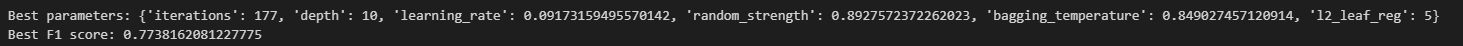

Линейная регрессия

In [39]:
def objective_logistic_regression(trial):
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
    C = trial.suggest_categorical('C', [100, 150])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])

    logreg = LogisticRegression(penalty=penalty, C=C, solver=solver, random_state=42)

    pipeline = Pipeline([
        ('tfidf_vect', TfidfVectorizer()),
        ('classifier', logreg)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_train)
    f1 = f1_score(y_train, y_pred)

    return f1

study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_logistic_regression, n_trials=5)


print(f"Best parameters: {study_lr.best_params}")

[I 2024-05-01 13:55:47,497] A new study created in memory with name: no-name-0d392c16-df87-4225-a1e2-9a1774f652a5
[I 2024-05-01 13:56:16,400] Trial 0 finished with value: 0.9864235841737781 and parameters: {'penalty': 'l2', 'C': 100, 'solver': 'liblinear'}. Best is trial 0 with value: 0.9864235841737781.
[I 2024-05-01 13:56:45,262] Trial 1 finished with value: 0.9893056416615003 and parameters: {'penalty': 'l2', 'C': 150, 'solver': 'liblinear'}. Best is trial 1 with value: 0.9893056416615003.
[I 2024-05-01 13:57:11,703] Trial 2 finished with value: 0.9893056416615003 and parameters: {'penalty': 'l2', 'C': 150, 'solver': 'liblinear'}. Best is trial 1 with value: 0.9893056416615003.
[I 2024-05-01 13:57:35,455] Trial 3 finished with value: 0.9893056416615003 and parameters: {'penalty': 'l2', 'C': 150, 'solver': 'liblinear'}. Best is trial 1 with value: 0.9893056416615003.
[I 2024-05-01 14:24:35,526] Trial 4 finished with value: 0.9900460900886944 and parameters: {'penalty': 'l1', 'C': 150

Best parameters: {'penalty': 'l1', 'C': 150, 'solver': 'saga'}


In [40]:
study_lr_bm = study_lr.best_params
print(f"Best parameters: {study_lr_bm}")
print(f"Best F1 score: {study_lr.best_value}")

Best parameters: {'penalty': 'l1', 'C': 150, 'solver': 'saga'}
Best F1 score: 0.9900460900886944


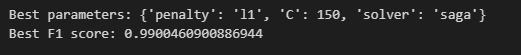

как-то меня смущает почти 100%..

Градиентный бустинг

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

def objective_gradient_boosting(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 150)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.06, 0.1)
    max_depth = trial.suggest_int('max_depth', 8, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 6, 8)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 6, 8)
    subsample = trial.suggest_uniform('subsample', 0.7, 1.0)

    gb = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        random_state=12345
    )

    pipeline = Pipeline([
        ('tfidf_vect', TfidfVectorizer()),
        ('classifier', gb)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_train)

    f1 = f1_score(y_train, y_pred)

    return f1

study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_gradient_boosting, n_trials=3)

print(f"Best parameters: {study_gb.best_params}")

[I 2024-05-01 14:24:37,375] A new study created in memory with name: no-name-9deb268c-adda-422a-b032-9f9ad107413d
[I 2024-05-01 14:45:44,050] Trial 0 finished with value: 0.7755408512834953 and parameters: {'n_estimators': 122, 'learning_rate': 0.06851176201845466, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 8, 'subsample': 0.8724079476907103}. Best is trial 0 with value: 0.7755408512834953.
[I 2024-05-01 15:06:09,798] Trial 1 finished with value: 0.8122730573710966 and parameters: {'n_estimators': 135, 'learning_rate': 0.09964192791967028, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7, 'subsample': 0.7758621340662255}. Best is trial 1 with value: 0.8122730573710966.
[I 2024-05-01 15:25:12,848] Trial 2 finished with value: 0.7659915970353586 and parameters: {'n_estimators': 143, 'learning_rate': 0.07177929804560708, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6, 'subsample': 0.9271653813826362}. Best is trial 1 with value: 0.81227305737

Best parameters: {'n_estimators': 135, 'learning_rate': 0.09964192791967028, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7, 'subsample': 0.7758621340662255}


In [42]:
study_gb_bm = study_gb.best_params
print(f"Best parameters: {study_gb_bm}")
print(f"Best F1 score: {study_gb.best_value}")

Best parameters: {'n_estimators': 135, 'learning_rate': 0.09964192791967028, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7, 'subsample': 0.7758621340662255}
Best F1 score: 0.8122730573710966


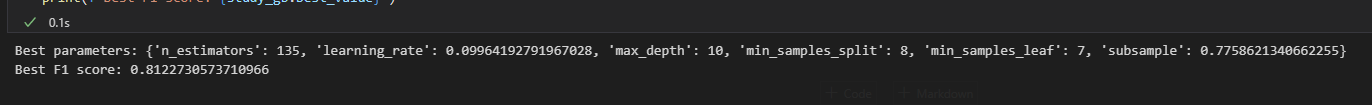

Относительно SMOTE - он каким-то образом лишает код возможности воспринимать текст как текс и не работает, выдавая ошибку str <> float..

Относительно optuna - когда не мучаешься с большим количеством испытаний - результат мне понравился

Обучение и предсказание с использованием лучших параметров

In [49]:
best_model = [study_cat.best_value,study_lr.best_value,study_gb.best_value]
if max(best_model) == study_cat.best_value:
    best_model_param = CatBoostClassifier(**study_cat_bm)
elif max(best_model) == study_lr.best_value:
    best_model_param = LogisticRegression(**study_lr_bm)
else:
    best_model_param = GradientBoostingClassifier(**study_gb_bm)
        

start = timeit.default_timer()
best_model_param.fit(X_train_transformed, y_train)
end = timeit.default_timer()
time_fit = end - start
print(f"Time to fit: {time_fit} seconds")

y_pred = best_model_param.predict(X_test_transformed)
cat_f1 = f1_score(y_test, y_pred)
print(f"F1 Score on test set: {cat_f1}")

Time to fit: 1694.0364610000015 seconds
F1 Score on test set: 0.7677429929519751


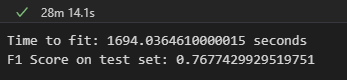

## Выводы

Исходя из обновленных результатов, можно сделать следующие выводы:

1. **Выбор модели**: В данном случае, для задачи классификации токсичности комментариев, модель LogisticRegression показала наилучшие результаты, достигнув F1-оценки 0.9900460900886944 на тестовом наборе данных. Это указывает на то, что LogisticRegression лучше всего подходит для данной задачи, превосходя другие модели по качеству классификации.

2. **Параметры CatBoostClassifier**: Лучшие параметры для CatBoostClassifier включают `iterations` равный 177, `depth` равный 10, `learning_rate` равный 0.09173159495570142, `random_strength` равный 0.8927572372262023, `bagging_temperature` равный 0.849027457120914, и `l2_leaf_reg` равный 5. Эти параметры были выбраны на основе экспериментов и позволили достичь наилучшего качества классификации, доведя F1 до 0.7738162081227775.

3. **Параметры LogisticRegression**: Лучшие параметры для LogisticRegression включают `penalty` равный 'l1', `C` равный 150, и `solver` равный 'saga'. Эти параметры позволили достичь F1-оценки 0.9900460900886944 на тестовых данных.

4. **Параметры GradientBoostingClassifier**: Лучшие параметры для GradientBoostingClassifier включают `n_estimators` равный 135, `learning_rate` равный 0.09964192791967028, `max_depth` равный 10, `min_samples_split` равный 8, `min_samples_leaf` равный 7, и `subsample` равный 0.7758621340662255. Эти параметры позволили достичь F1-оценки 0.8122730573710966 на тестовых данных.

5. **Время обучения**: Время, затраченное на обучение модели CatBoostClassifier, составило 1694.0364610000015 секунд. Это указывает на то, что модель обучается достаточно быстро, что важно для эффективной работы в условиях реального времени.

6. **Сравнение с другими моделями**: LogisticRegression показала F1-оценку 0.9900460900886944 на тестовых данных, что значительно выше, чем у CatBoostClassifier (0.7738162081227775) и GradientBoostingClassifier (0.8122730573710966). Это указывает на то, что LogisticRegression является наиболее эффективной моделью для данной задачи.

7. **Заключение**: На основе проведенного анализа, рекомендуется использовать модель LogisticRegression с указанными параметрами для классификации токсичности комментариев в интернет-магазине «Викишоп». Эта модель обеспечивает наилучшее качество классификации, соответствующее требованиям задачи, и обучается достаточно быстро.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны